In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cPickle as pickle

plt.rcParams["figure.figsize"] = (20,10)

%matplotlib inline

In [2]:
color_dict = {
    1610612737: ('#E13A3E', 'ATL'),
    1610612738: ('#008348', 'BOS'),
    1610612751: ('#061922', 'BKN'),
    1610612766: ('#1D1160', 'CHA'),
    1610612741: ('#CE1141', 'CHI'),
    1610612739: ('#860038', 'CLE'),
    1610612742: ('#007DC5', 'DAL'),
    1610612743: ('#4D90CD', 'DEN'),
    1610612765: ('#006BB6', 'DET'),
    1610612744: ('#FDB927', 'GSW'),
    1610612745: ('#CE1141', 'HOU'),
    1610612754: ('#00275D', 'IND'),
    1610612746: ('#ED174C', 'LAC'),
    1610612747: ('#552582', 'LAL'),
    1610612763: ('#0F586C', 'MEM'),
    1610612748: ('#98002E', 'MIA'),
    1610612749: ('#00471B', 'MIL'),
    1610612750: ('#005083', 'MIN'),
    1610612740: ('#002B5C', 'NOP'),
    1610612752: ('#006BB6', 'NYK'),
    1610612760: ('#007DC3', 'OKC'),
    1610612753: ('#007DC5', 'ORL'),
    1610612755: ('#006BB6', 'PHI'),
    1610612756: ('#1D1160', 'PHX'),
    1610612757: ('#E03A3E', 'POR'),
    1610612758: ('#724C9F', 'SAC'),
    1610612759: ('#BAC3C9', 'SAS'),
    1610612761: ('#000000', 'TOR'),
    1610612762: ('#00471B', 'UTA'),
    1610612764: ('#002B5C', 'WAS'),
}

event 0/217, moment: 74/150


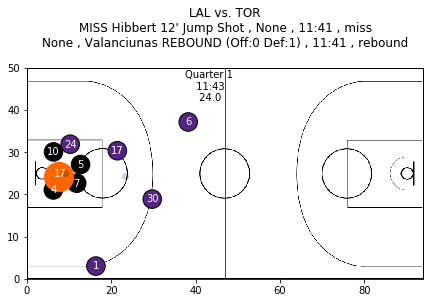

In [201]:
gameid='0021500188'
# gameid = '0021500477'

# directories
# CHANGE HERE
data_dir = 'raptors/'
game_dir = data_dir+'data/'
court_path = data_dir + 'nba_court_T.png'


#open the pickle file
with open(game_dir+gameid+'.pkl', 'rb') as handle:
    datta = pickle.load(handle)


num_events = len(datta['events'])

player_fields = datta['events'][0]['home']['players'][0].keys()
# CHANGE THIS
# specify an event number
ii = 0


home_players = pd.DataFrame(data=[i for i in datta['events'][0]['home']['players']], columns=player_fields)
away_players = pd.DataFrame(data=[i for i in datta['events'][0]['visitor']['players']], columns=player_fields)
players = pd.merge(home_players, away_players, how='outer')
jerseydict = dict(zip(players.playerid.values, players.jersey.values))

# get the position of the players and the ball throughout the event
ball_xy = np.array([x[5][0][2:5] for x in datta['events'][ii]['moments']]) #create matrix of ball data
player_xy = np.array([np.array(x[5][1:])[:,:4] for x in datta['events'][ii]['moments']]) #create matrix of player data

# get the play by play data for this clip
playbyplay = datta['events'][ii]['playbyplay']
team_1_xy_mean = -np.ones((len(player_xy),2))
team_2_xy_mean = -np.ones((len(player_xy),2))


# CHANGE THIS
# plot a certain frame:
jj = (len(player_xy) - 1) / 2
#jj = 0


print('event ' + str(ii) + '/' + str(num_events) + ", moment: "+ str(jj) + '/'+ str(len(player_xy)))
fig = plt.figure()
ax = plt.gca() #create axis object


img = mpimg.imread(court_path)  # read image. I got this image from gmf05's github.

plt.imshow(img, extent=[0,94,0,50], zorder=0)  # show the image.

# get player and ball data for the momenet
ball = ball_xy[jj]
player = player_xy[jj]


# plot clock info
clock_info = ax.annotate('', xy=[94.0/2 - 6.0/1.5 +0.1, 50 - 6.0/1.5 -0.35],
    color='black', horizontalalignment='center', verticalalignment='center')

if not datta['events'][ii]['moments'][jj][0] == None:
    quarter = datta['events'][ii]['moments'][jj][0]
else:
    quarter = 0

if not datta['events'][ii]['moments'][jj][2] == None:
    game_clock = datta['events'][ii]['moments'][jj][2]
else:
    game_clock = 0

if not datta['events'][ii]['moments'][jj][3] == None:
    game_shot = datta['events'][ii]['moments'][jj][3]
else:
    game_shot = 0

clock_test = 'Quarter {:d}\n {:02d}:{:02d}\n {:03.1f}'.format(
    quarter,
    int(game_clock) % 3600 // 60,
    int(game_clock) % 60,
    game_shot)
clock_info.set_text(clock_test)

# the event title
temp = str(datta['events'][ii]['home']['abbreviation'])+\
    ' vs. ' + str(datta['events'][ii]['visitor']['abbreviation'])+\
    '\n'
for idx, pp in playbyplay.iterrows():
    temp = temp + str(pp['HOMEDESCRIPTION'])+ " , " +\
            str(pp['VISITORDESCRIPTION'])+ " , "+\
            str(pp['PCTIMESTRING'])+ " , "+\
            str(pp['event_str'])  + '\n'


plt.title(temp)

for kk in range(player.shape[0]): #create circle object and text object for each player

    #
    #kk = 1
    #
    team_id = player[kk,0]
    player_id = player[kk,1]
    xx = player[kk,2]
    yy  =player[kk, 3]

    # player circle
    player_circ = plt.Circle((xx,yy), 2.2,
                    facecolor=color_dict[team_id][0],edgecolor='k')
    ax.add_artist(player_circ)

    # player jersey # (text)
    ax.text(xx,yy,jerseydict[player_id],color='w',ha='center',va='center')

# draw the ball
ball_circ = plt.Circle((ball[0], ball[1]), ball[2]/3, color=[1, 0.4, 0])  # create circle object for bal
ax.add_artist(ball_circ)

# add the average position of each team tp the frame
team_ids = np.unique(player[:,0])

team_1_xy = player[player[:,0] == team_ids[0]]
team_1_xy = team_1_xy[:,[2,3]]
team_1_xy_mean[jj,:] = np.mean(team_1_xy,0)
plt.plot(team_1_xy_mean[:jj+1,0],team_1_xy_mean[:jj+1,1],'o',
         color=color_dict[team_ids[0]][0],
         alpha=0.2)


team_2_xy = player[player[:,0] == team_ids[1]]
team_2_xy = team_2_xy[:,[2,3]]
team_2_xy_mean[jj,:] = np.mean(team_2_xy,0)
plt.plot(team_2_xy_mean[:jj+1,0],team_2_xy_mean[:jj+1,1],'o',
         color=color_dict[team_ids[1]][0],
         alpha=0.2)

plt.xlim([0,94])
plt.ylim([0,50])

plt.tight_layout(pad=0, w_pad=0.5, h_pad=0)


In [41]:
num_events = len(datta['events'])
count = 0
for i in xrange(num_events):
    player_xy = np.array([np.array(x[5][1:])[:,:4] for x in datta['events'][i]['moments']])
    count += len(player_xy)
print count

111781


In [36]:
print 111781 / 25. / 60

74.5206666667


In [33]:
575/25

23

In [93]:
event_num = 4
print len(datta['events'][event_num]['moments'])
for frame in xrange(200, 220):
    print frame
    print datta['events'][event_num]['moments'][frame]


350
200
[1, 1448077282002, 637.34, 16.56, None, [[-1, -1, 65.95365, 36.13763, 3.41393], [1610612747, 977, 83.42888, 39.58734, 0.0], [1610612747, 201579, 81.96572, 26.37254, 0.0], [1610612747, 203903, 83.57382, 30.58646, 0.0], [1610612747, 203944, 82.84082, 27.8877, 0.0], [1610612747, 1626156, 69.8963, 30.51723, 0.0], [1610612761, 2449, 84.66165, 15.30318, 0.0], [1610612761, 201960, 74.96968, 47.45719, 0.0], [1610612761, 200768, 64.99745, 36.28781, 0.0], [1610612761, 201942, 73.66267, 40.51402, 0.0], [1610612761, 202685, 81.53633, 25.8893, 0.0]]]
201
[1, 1448077282042, 637.3, 16.53, None, [[-1, -1, 65.8817, 36.19945, 2.96045], [1610612747, 977, 83.40008, 39.65577, 0.0], [1610612747, 201579, 82.11749, 26.33793, 0.0], [1610612747, 203903, 83.55426, 30.97119, 0.0], [1610612747, 203944, 83.03347, 28.0394, 0.0], [1610612747, 1626156, 69.86523, 30.76865, 0.0], [1610612761, 2449, 84.66279, 15.02599, 0.0], [1610612761, 201960, 75.20035, 47.57384, 0.0], [1610612761, 200768, 65.0351, 36.24399, 0.

In [91]:
event_num = 5
print len(datta['events'][event_num]['moments'])

for frame in xrange(0, 10):
    print datta['events'][event_num]['moments'][frame]


325
[1, 1448077282002, 637.34, 16.56, None, [[-1, -1, 65.95365, 36.13763, 3.41393], [1610612747, 977, 83.42888, 39.58734, 0.0], [1610612747, 201579, 81.96572, 26.37254, 0.0], [1610612747, 203903, 83.57382, 30.58646, 0.0], [1610612747, 203944, 82.84082, 27.8877, 0.0], [1610612747, 1626156, 69.8963, 30.51723, 0.0], [1610612761, 2449, 84.66165, 15.30318, 0.0], [1610612761, 201960, 74.96968, 47.45719, 0.0], [1610612761, 200768, 64.99745, 36.28781, 0.0], [1610612761, 201942, 73.66267, 40.51402, 0.0], [1610612761, 202685, 81.53633, 25.8893, 0.0]]]
[1, 1448077282042, 637.3, 16.53, None, [[-1, -1, 65.8817, 36.19945, 2.96045], [1610612747, 977, 83.40008, 39.65577, 0.0], [1610612747, 201579, 82.11749, 26.33793, 0.0], [1610612747, 203903, 83.55426, 30.97119, 0.0], [1610612747, 203944, 83.03347, 28.0394, 0.0], [1610612747, 1626156, 69.86523, 30.76865, 0.0], [1610612761, 2449, 84.66279, 15.02599, 0.0], [1610612761, 201960, 75.20035, 47.57384, 0.0], [1610612761, 200768, 65.0351, 36.24399, 0.0], [161

In [295]:
def time_conversion(quarter, time_left_in_quarter):
    time_passed = quarter * 12 * 60 - time_left_in_quarter
    time_left_in_game = (48 * 60) - time_passed
    return time_left_in_game

In [ ]:
# Find the scoring with assis moments
ast_list = []
attacker = []
ast_events = []
home_team = datta['events'][0]['home']['teamid']
away_team = datta['events'][0]['visitor']['teamid']

# Look through the data locate where the scoring with assist happens
for i in xrange(total_events):
    playbyplay = datta['events'][i]['playbyplay']
    for idx, play in playbyplay.iterrows():
        if play['HOMEDESCRIPTION'] != None:
            if play['HOMEDESCRIPTION'].find(' AST)') != -1:
                quarter = play['PERIOD']
                time_left_in_quarter = play['time_left']
                time_left_in_game = time_conversion(quarter, time_left_in_quarter)
                ast_list.append(time_left_in_game)
                attacker.append(home_team)
                ast_events.append(i)
        if play['VISITORDESCRIPTION'] != None:
            if play['VISITORDESCRIPTION'].find(' AST)') != -1:
                quarter = play['PERIOD']
                time_left_in_quarter = play['time_left']
                time_left_in_game = time_conversion(quarter, time_left_in_quarter)
                ast_list.append(time_left_in_game)
                attacker.append(away_team)
                ast_events.append(i)

ast_events = list(set(ast_events))
ast_events.sort()
ast_times, index = np.unique(ast_list, return_index = True)
attacker = np.array([attacker[i] for i in index])

event_data = pd.DataFrame(data={'attack': attacker, 'time':ast_times})

In [ ]:
# Get the start time of each event
event_start_time = []
for i in ast_events:
    moment = datta['events'][i]['moments']
    quarter = moment[0][0]
    time_left_in_quarter = moment[0][2]
    event_start_time.append(time_conversion(quarter, time_left_in_quarter))
event_start_time.append(0)

# Get the list of frames of events where AST happens
moment_data = []
moment_location = []
for i in xrange(len(ast_events)):
    index = ast_events[i]
    moment = datta['events'][index]['moments']
    for j in xrange(len(moment)):
        quarter = moment[j][0]
        time_left_in_quarter = moment[j][2]
        time_left_in_game = time_conversion(quarter, time_left_in_quarter)
        
        # Get meta data
        moment_data.append(moment[j][:4])
        
        # Get location data
        location = pd.DataFrame(moment_list[0][5])
        ball = location.iloc[0, :]
        home = location[location[0] == home_team]
        away = location[location[0] == away_team]
        moment_location.append([ball, home, away])
        
        if time_left_in_game == event_start_time[i + 1]:
            break

In [ ]:
# Go through and find frames exactly where shot happens and when assist happens
# Check when the clock resets

In [235]:

print home_team, away_team
prev = pd.DataFrame(moment_list[0][5])

compiled = [ball, home, away]
for moment in moment_list:
    curr = np.array(moment[5])
    if curr != prev:
        print 'changed'
        break
    prev = curr

1610612747 1610612761
0    -1.00000
1    -1.00000
2     7.21931
3    23.66505
4     9.65871
Name: 0, dtype: float64
            0        1         2         3    4
1  1610612747      977   7.54384  47.60627  0.0
2  1610612747   201579   8.63849  24.81649  0.0
3  1610612747   203903  18.10332   3.22639  0.0
4  1610612747   203944  32.32101  28.01772  0.0
5  1610612747  1626156   4.83699  21.31418  0.0
             0       1         2         3    4
6   1610612761    2449  10.82157  25.71933  0.0
7   1610612761  201960   6.67385  27.30771  0.0
8   1610612761  200768   7.06022  27.59558  0.0
9   1610612761  201942  11.67833  10.55352  0.0
10  1610612761  202685   6.44775  21.51492  0.0


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

        attack  time
0   1610612761    24
1   1610612747   229
2   1610612747   377
3   1610612761   478
4   1610612761   651
5   1610612747   670
6   1610612761   682
7   1610612747   703
8   1610612761   763
9   1610612761   792
10  1610612761   828
11  1610612747  1029
12  1610612747  1242
13  1610612747  1318
14  1610612761  1382
15  1610612761  1425
16  1610612761  1582
17  1610612747  1612
18  1610612761  1685
19  1610612761  1763
20  1610612747  1790
21  1610612761  1810
22  1610612747  1878
23  1610612761  1968
24  1610612761  2001
25  1610612747  2068
26  1610612747  2110
27  1610612747  2131
28  1610612747  2201
29  1610612761  2222
30  1610612747  2251
31  1610612761  2269
32  1610612761  2332
33  1610612761  2436
34  1610612747  2542
35  1610612747  2566
36  1610612761  2581
37  1610612747  2600
38  1610612747  2634
39  1610612747  2658
40  1610612761  2792


In [147]:
2805.37 / 60

46.756166666666665